<a href="https://colab.research.google.com/github/Amith-kuppili/chat_gpt_model-language_translation/blob/main/TRANSFORMERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from typing import Text
import tensorflow as tf

Text_file=tf.keras.utils.get_file(
    fname='fra-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract=True
)
print('Text_file')

Text_file


In [17]:
import pathlib
extracted_dir = pathlib.Path(Text_file).parent
Text_file = extracted_dir / 'fra-eng_extracted' / 'fra.txt'
print(Text_file)

/root/.keras/datasets/fra-eng_extracted/fra.txt


In [18]:
with open(Text_file) as fp:
    test_pair=[line for line in fp]

In [19]:
import os
print(os.listdir('/root/.keras/datasets/'))

['fra-eng.zip', 'fra-eng_extracted']


In [20]:
import os
print(os.listdir('/root/.keras/datasets/fra-eng_extracted/'))

['_about.txt', 'fra.txt']


In [21]:
import random
for _ in range(5):
    print(random.choice(test_pair))

I will act on your advice.	J'agirai selon tes conseils.

I asked you to be quiet.	Je t'ai demandé d'être silencieuse.

Christmas is coming soon.	Bientôt Noël.

I didn't sleep all night.	Je n'ai pas dormi de toute la nuit.

It's true!	C'est vrai !



In [22]:
import unicodedata
import re

def normalize(text):
  # Split the line into English and French parts first
  eng, fre = text.strip().lower().split('\t')

  # Normalize and clean the English part
  eng = unicodedata.normalize('NFKC', eng)
  eng = re.sub(r'([,.!?])', r' \1', eng)
  eng = re.sub(r'[^a-zA-Z,.!?]+', ' ', eng)
  eng = re.sub(r'\s+', ' ', eng).strip()

  # Normalize and clean the French part
  fre = unicodedata.normalize('NFKC', fre)
  fre = re.sub(r'([,.!?])', r' \1', fre)
  fre = re.sub(r'[^a-zA-Z,.!?]+', ' ', fre)
  fre = re.sub(r'\s+', ' ', fre).strip()

  # Add start and end tokens to the French part
  fre = '[start] ' + fre + ' [end]'

  return eng, fre

In [23]:
with open(Text_file) as fp:
    test_pair=[normalize(line) for line in fp]

In [24]:
for _ in range(5):
  print(random.choice(test_pair))

('excuse me , but i can barely hear you .', '[start] excusez moi , mais vous tes difficilement audible . [end]')
('he lives within his means .', '[start] il vit selon ses moyens . [end]')
('be nicer to your brother .', '[start] soyez plus gentille avec votre fr re ! [end]')
('young people love adventure .', '[start] les jeunes aiment l aventure . [end]')
('everyone has faults .', '[start] tout le monde des d fauts . [end]')


In [25]:
eng_tokens_set, fre_tokens_set = set(), set()
eng_maxlen, fre_maxlen = 0, 0

for eng, fre in test_pair:
  eng_tokens = eng.split()
  fre_tokens = fre.split()

  eng_tokens_set.update(eng_tokens)
  fre_tokens_set.update(fre_tokens)

  eng_maxlen = max(eng_maxlen, len(eng_tokens))
  fre_maxlen = max(fre_maxlen, len(fre_tokens))

print(f"Number of unique English tokens: {len(eng_tokens_set)}")
print(f"Number of unique French tokens: {len(fre_tokens_set)}")
print(f"Maximum English sentence length: {eng_maxlen}")
print(f"Maximum French sentence length: {fre_maxlen}")

Number of unique English tokens: 13749
Number of unique French tokens: 19770
Maximum English sentence length: 52
Maximum French sentence length: 68


In [29]:
import pickle
with open('text_pairs.pickle','wb') as fp:
  pickle.dump(test_pair,fp)

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pickle

# Load preprocessed text pairs
with open("text_pairs.pickle", 'rb') as fp:
    test_pair = pickle.load(fp)

In [31]:
# Shuffle the data
import random
random.shuffle(test_pair)

# Split into train and test sets
n_val = int(0.15 * len(test_pair))
n_train = len(test_pair) - 2 * n_val
train_pair = test_pair[:n_train]
test_pair = test_pair[n_train: n_train + n_val]

In [34]:
# Vocabulary sizes and sequence length
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

# Initialize TextVectorization layers
eng_vect = TextVectorization(
    max_tokens=vocab_en,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=seq_length
)

fre_vect = TextVectorization(
    max_tokens=vocab_fr,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=seq_length + 1  # +1 for start token
)

# Adapt TextVectorization layers to training data
train_eng = [pair[0] for pair in train_pair]
train_fre = [pair[1] for pair in train_pair]

eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)

# Define function to format dataset
def format_dataset(eng, fre):
    eng = eng_vect(eng)
    fre = fre_vect(fre)
    source = {'encode_inp': eng,
              'decode_inp': fre[:, :-1]
              }
    target = fre[:, 1:]
    return (source, target)

# Define function to create dataset
def make_dataset(pairs, batchsize=64):
    eng_text, fre_text = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))
    return dataset.shuffle(2048).batch(batchsize).map(format_dataset).prefetch(16).cache()

# Create TensorFlow datasets for training and testing
train_ds = make_dataset(train_pair)
test_ds = make_dataset(test_pair)

 **Positional Embedding**

In [35]:
import numpy as np

# Function to generate positional encoding matrix
def pos_enc_matrix(L, d, n=10000):
    assert d % 2 == 0
    d2 = d // 2

    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)
    i = np.arange(d2).reshape(1, -1)

    denom = np.power(n, -i / d2)
    args = k * denom

    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

# Custom Keras layer for positional embedding
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        matrix = pos_enc_matrix(seq_length, embed_dim)

        self.positional_embedding = tf.constant(matrix, dtype='float32')

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.positional_embedding

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'seq_length': self.seq_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })

# Usage and Validation
vocab_en = 10000
seq_length = 25

for inputs, targets in train_ds.take(1):
    embed_en = PositionalEmbedding(seq_length, vocab_en, embed_dim=512)
    en_emb = embed_en(inputs['encode_inp'])
    print(en_emb._keras_mask)

tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 25), dtype=bool)


**------------------------------------------------NEURAL NETWORK-------------------------------------------------------------**

**Self-Attention Layer**

In [36]:
import tensorflow as tf

def self_attention(input_shape, prefix='att', mask=False, **kwargs):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in1")

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_att1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm1')
    add = tf.keras.layers.Add(name=f'{prefix}_add1')

    # Apply attention mechanism
    attout = attention(query=inputs, value=inputs, key=inputs, use_causal_mask=mask)

    # Apply normalization and residual connection
    output = norm(add([inputs, attout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f"{prefix}_att")

    return model

In [39]:
seq_length=25
key_dim=128
num_heads=8
dropout=0.1
model=self_attention(input_shape=(seq_length,key_dim),num_heads=num_heads,key_dim=key_dim,dropout=dropout)


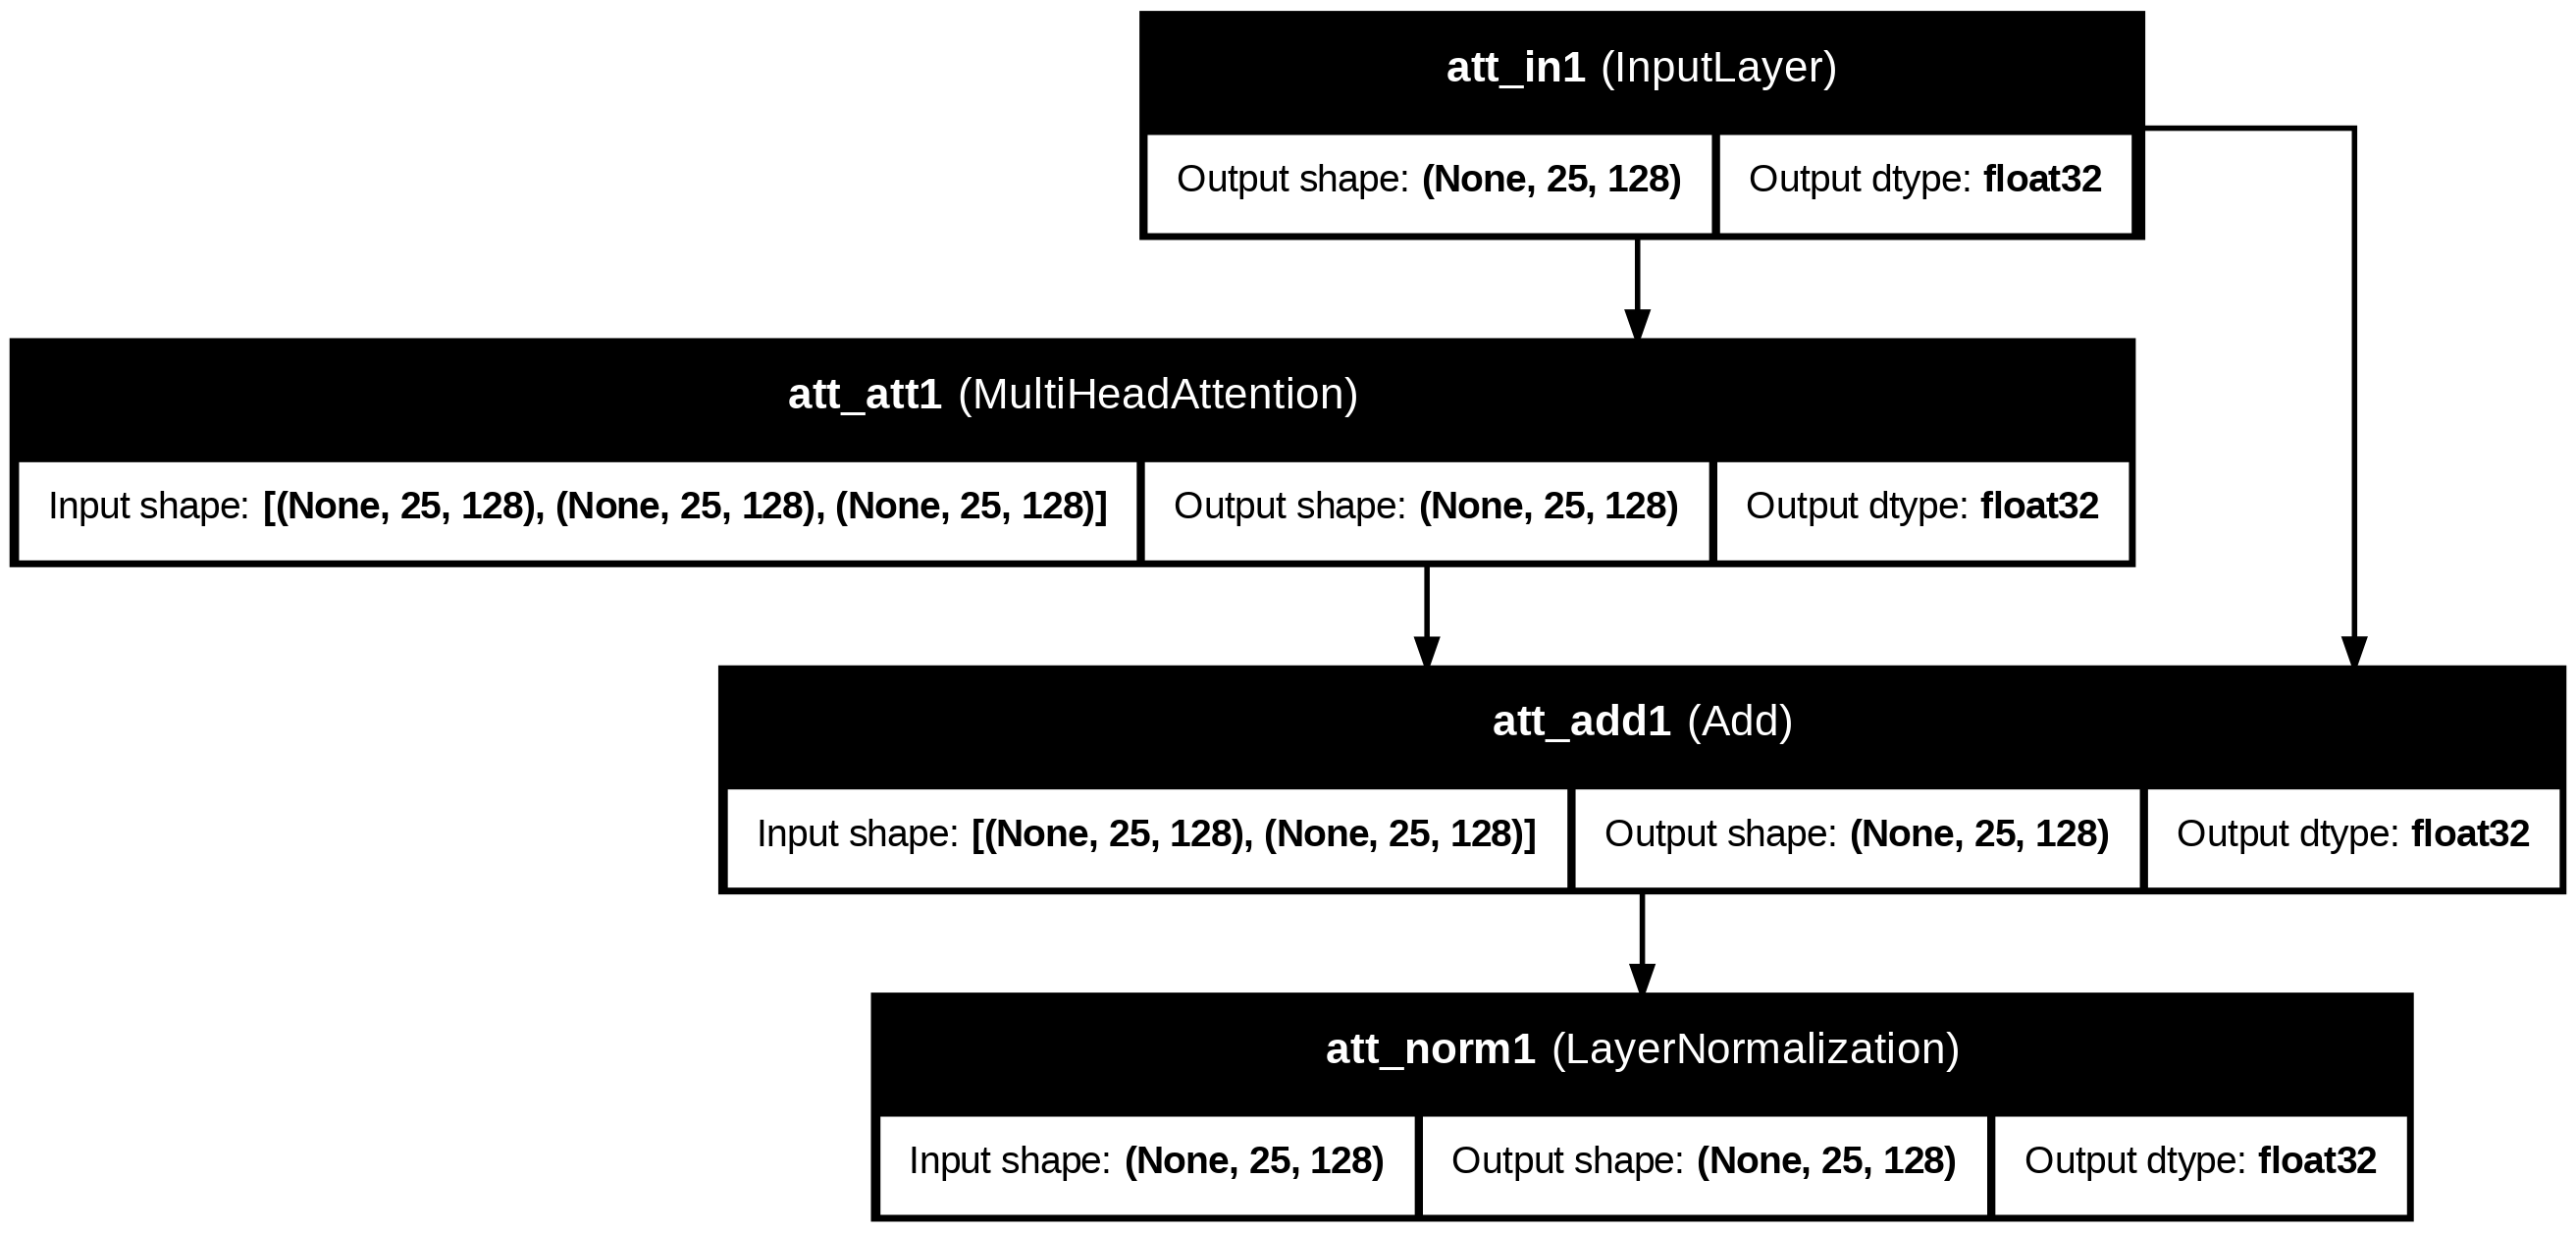

In [41]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

**Cross-Attention Layer**

In [43]:
def cross_attention(input_shape, context_shape, prefix='att', **kwargs):
    # Define inputs
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32', name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in2')

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f'{prefix}_att2', **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm2')
    add = tf.keras.layers.Add(name=f'{prefix}_add2')

    # Apply attention mechanism
    attout = attention(query=inputs, key=context, value=context)

    # Apply normalization and residual connection
    output = norm(add([attout, inputs]))

    # Create the model
    model = tf.keras.Model(inputs=[context, inputs], outputs=output, name=f'{prefix}_crs_at')

    return model

In [44]:
model=cross_attention(input_shape=(seq_length,key_dim),num_heads=num_heads,key_dim=key_dim,dropout=dropout,context_shape=(seq_length,key_dim))

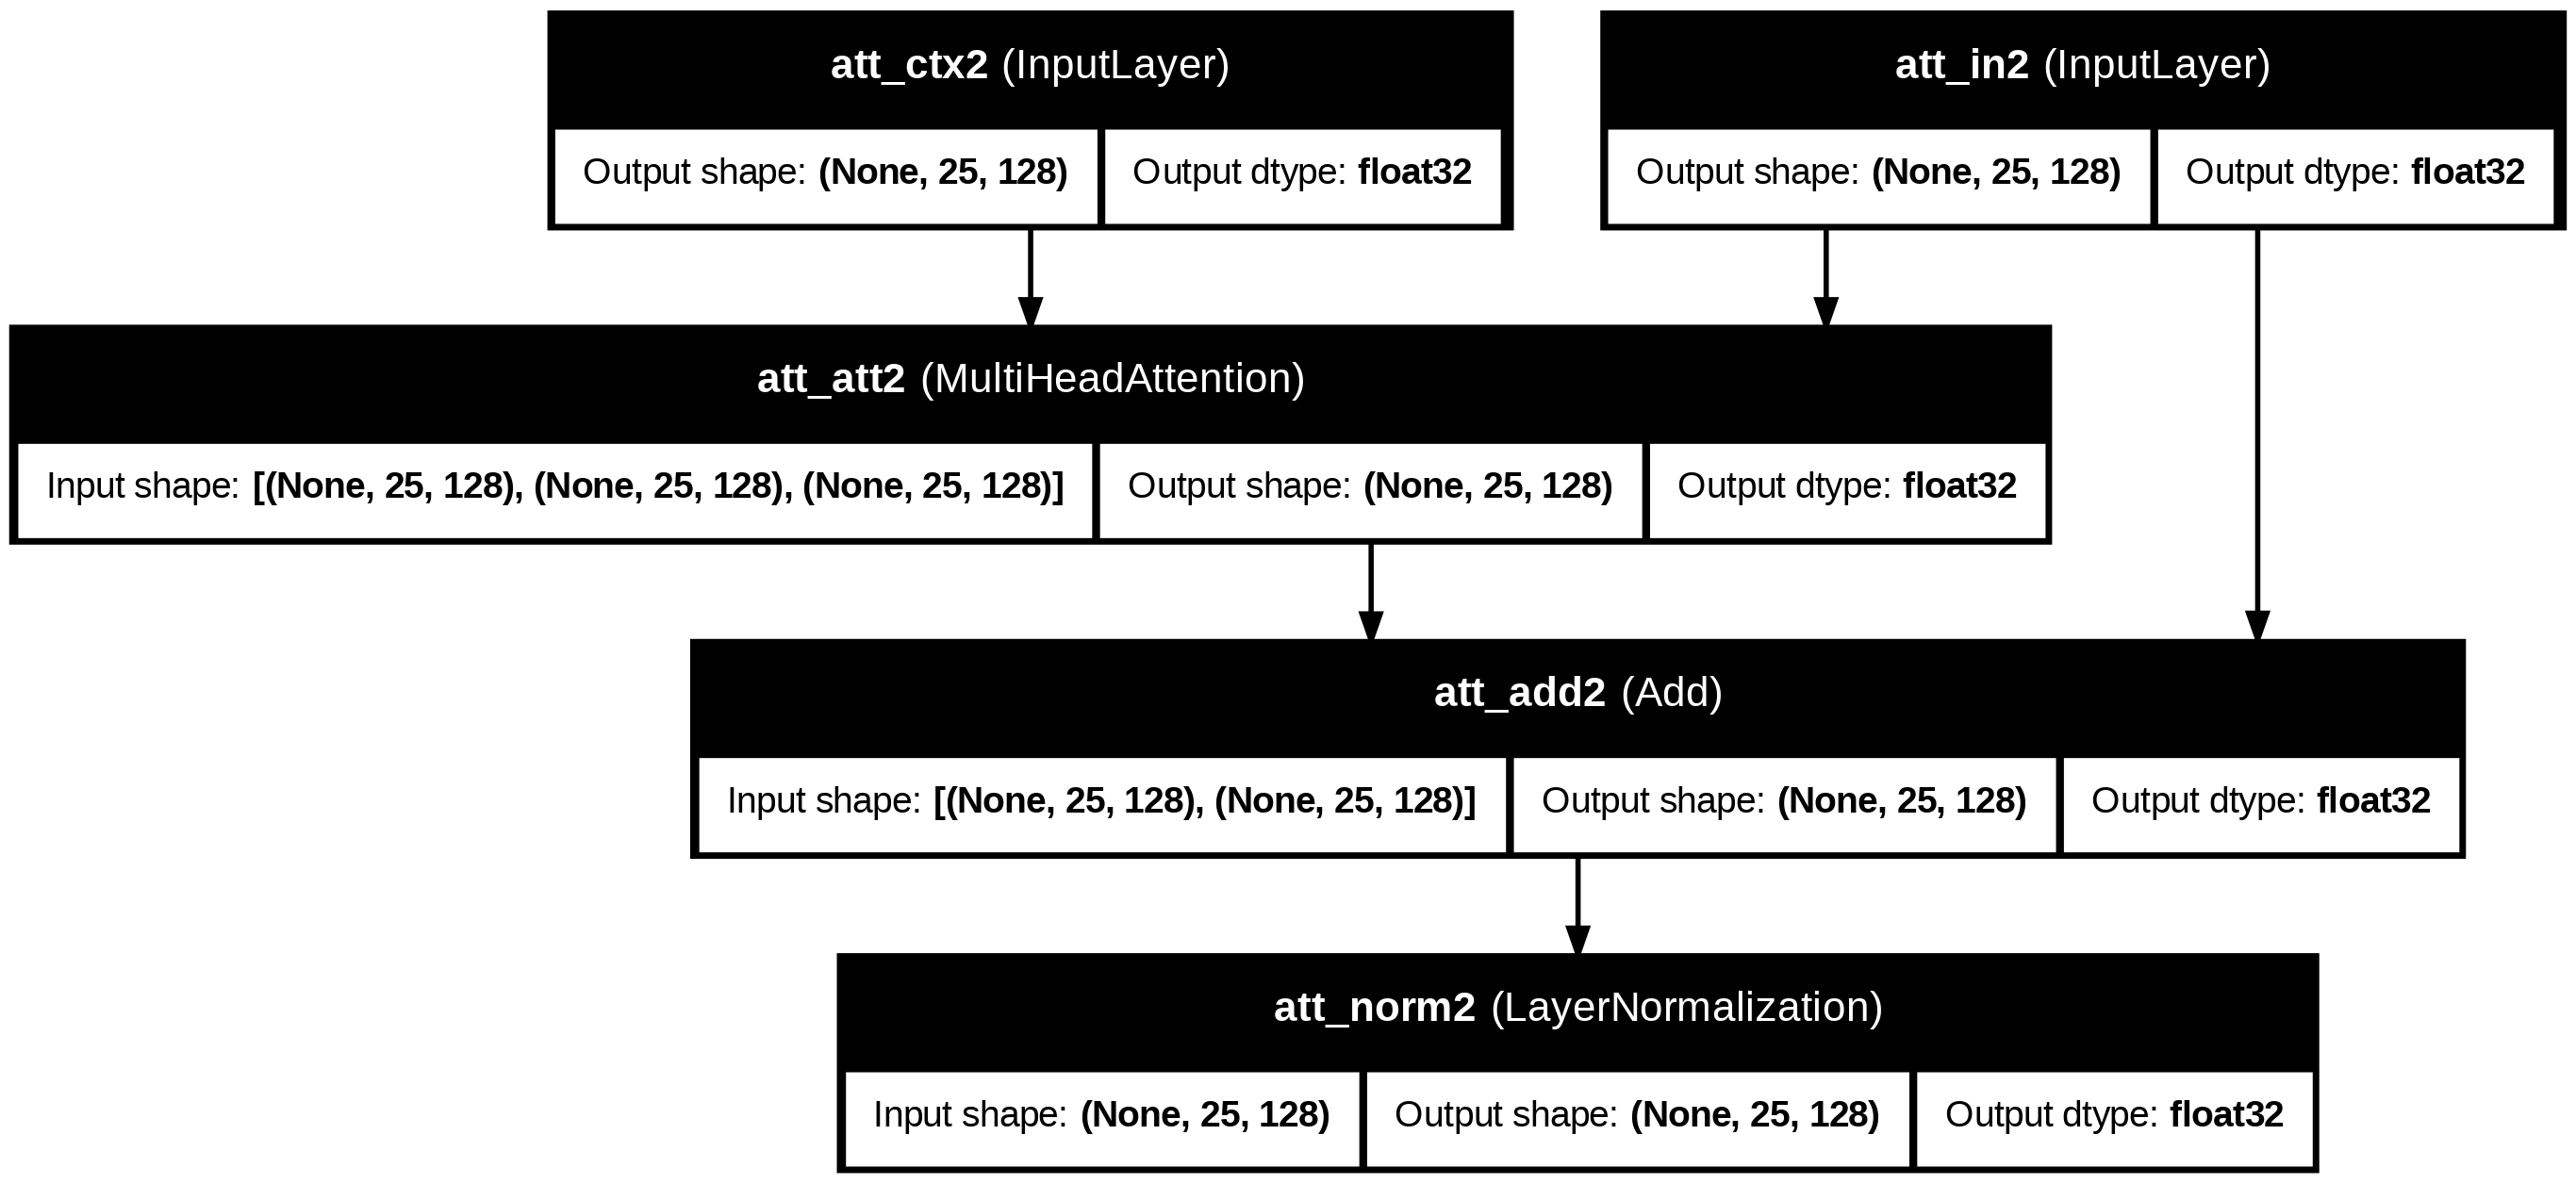

In [45]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

**Feed-Forward Layer**

In [37]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=.1, prefix='ff'):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in3')

    # Dense layers
    dense1 = tf.keras.layers.Dense(ff_dim, name=f'{prefix}_ff1', activation='relu')
    dense2 = tf.keras.layers.Dense(model_dim, name=f'{prefix}_ff2')
    drop = tf.keras.layers.Dropout(dropout, name=f'{prefix}_drop')
    add = tf.keras.layers.Add(name=f"{prefix}_add3")

    # Apply feed-forward transformation
    ffout = drop(dense2(dense1(inputs)))

    # Layer normalization and residual connection
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm3')
    output = norm(add([inputs, ffout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f'{prefix}_ff')

    return model

In [46]:
ff_dim=512
model=feed_forward(input_shape=(seq_length,key_dim),model_dim=key_dim,ff_dim=ff_dim)

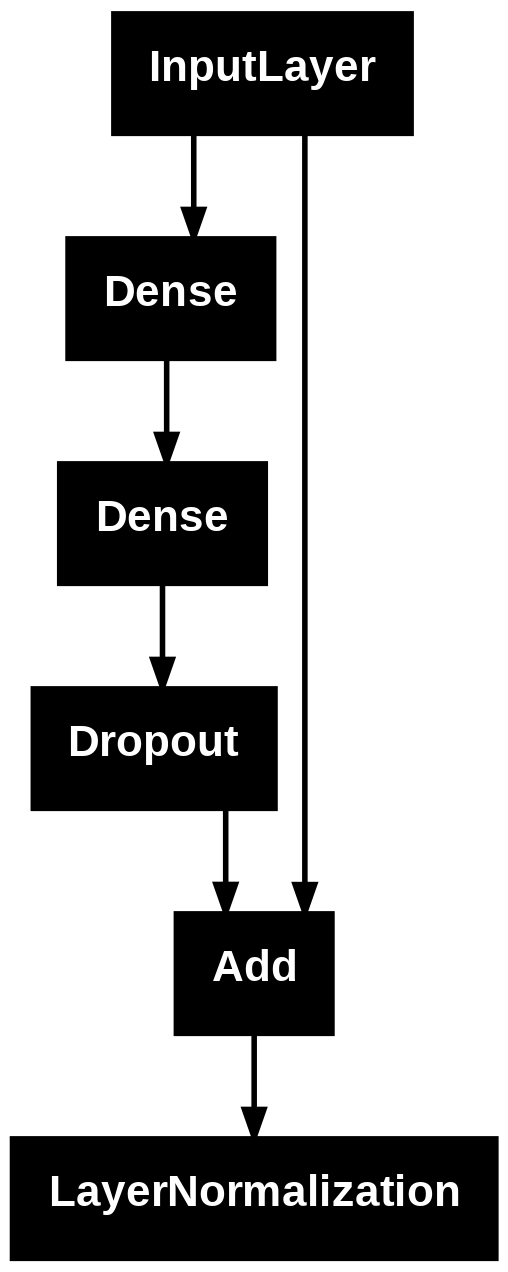

In [48]:
tf.keras.utils.plot_model(model)

**Encoder Layer**

In [49]:
import tensorflow as tf

def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='enc', **kwargs):
    # Define a Sequential model for the encoder
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0'), # Input layer
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs), # Self-attention layer
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix) # Feed-forward layer
    ])

    return model

**Decoder Layer**

In [50]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='dec', **kwargs):
    # Define inputs for decoder
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0')
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_ctx0')

    # Self-attention and cross-attention layers
    att_model = self_attention(input_shape, key_dim=key_dim, mask=True, prefix=prefix, **kwargs)
    cross_model = cross_attention(input_shape, input_shape, key_dim=key_dim, prefix=prefix, **kwargs)

    # Feed-forward layer
    ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    # Connect layers
    x = att_model(inputs)
    x = cross_model([context, x])
    output = ff_model(x)

    # Define decoder model
    model = tf.keras.Model(inputs=[inputs, context], outputs=output, name=prefix)

    return model

**Transformer Model**

In [64]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout=0.1, name='transformer'):
    # Define encoder and decoder inputs
    input_enc = tf.keras.layers.Input(shape=(seq_length,), dtype='int32', name='encode_inp')
    input_dec = tf.keras.layers.Input(shape=(seq_length,), dtype='int32', name='decode_inp')

    # Positional embeddings for encoder and decoder inputs
    emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name='embed_enc')
    emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name='embed_dec')

    # Create encoder and decoder layers
    encoders = [encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads)
                for i in range(num_layers)]

    # Final dense layer
    final = tf.keras.layers.Dense(vocab_size_fr, name='linear')

    # Apply encoder and decoder layers to inputs
    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])

    # Generate output
    output = final(x2)

    try:
        del output.keras_mask
    except:
        pass

    # Define transformer model
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)

    return model

**Custom Learning Rate Schedule**

In [52]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps=40000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    # Convert step to float32
    step = tf.cast(step, dtype=tf.float32)
    # Calculate learning rate schedule
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    # Configuration for serialization
    config ={
      "key_dim": self.key_dim,
      "warmup_steps": self.warmup_steps
    }
    return config

# Define key dimension and create learning rate schedule
key_dim = 128
lr_schedule = CustomSchedule(key_dim)

***Masked Loss Function***

In [65]:
def masked_loss(label, pred):
  # Create mask for non-padded tokens
  mask = label != 0

  # Sparse categorical cross-entropy loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  # Apply mask to loss
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  # Compute average loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss

**Masked Accuracy Metric**

In [ ]:
def mask_accuracy(label, pred):
  # Convert predictions to class labels
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  # Calculate match between labels and predictions
  match = label == pred

  # Apply mask to match
  mask = label != 0
  match = match & mask

  # Compute accuracy
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)

**Compile and Train the Model**

In [ ]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Create the transformer model
transformer_model = transformer(
    num_layers=4,
    num_heads=8,
    seq_length=seq_length,
    key_dim=key_dim,
    ff_dim=ff_dim,
    vocab_size_en=vocab_en,
    vocab_size_fr=vocab_fr,
    dropout=0.1
)

# Compile the model with custom loss and metrics
transformer_model.compile(loss=masked_loss, optimizer=optimizer, metrics=[mask_accuracy])
transformer_model.summary()

# Train the model
history = transformer_model.fit(train_ds, epochs=20, validation_data=test_ds)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ sequential[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_3[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  39/1828 ━━━━━━━━━━━━━━━━━━━━ 4:01:27 8s/step - loss: 9.9110 - mask_accuracy: 4.5120e-05

**Visualizing Training History**

In [ ]:
import matplotlib.pyplot as plt

# Visualizing Training History
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training history')
x = list(range(1, 21))  # Assuming 20 epochs
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="mask_accuracy")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_mask_accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="lower right")
plt.show()

**Model Testing**

In [ ]:
def translate(sentence):
    # Encode input sentence
    enc_tokens = eng_vect([sentence])
    lookup = list(fra_vect.get_vocabulary())
    start_sent, end_sent = "[start]", "[end]"
    output_sent = [start_sent]
    for i in range(seq_length):
        # Prepare decoder input
        vector = fra_vect([" ".join(output_sent)])
        assert vector.shape == (1, seq_length + 1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_length)
        # Generate predictions
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        # Decode predicted token
        word = lookup[np.argmax(pred[0, i, :])]
        output_sent.append(word)
        if word == end_sent:
            break
    return output_sent

# Test the model on sample test cases
test_count = 20
for n in range(test_count):
    eng_sent, fre_sent = random.choice(test_pairs)
    translated = translate(eng_sent)
    print(f"Test case: {n}")
    print(f"English sentence: {eng_sent}")
    print(f"Translated sentence: {' '.join(translated)}")
    print(f"French sentence: {fre_sent}")
    print()